<a href="https://colab.research.google.com/github/IEwaspbusters/KopuruVespaCompetitionIE/blob/main/Competition_subs/2021-04-28_submit/batch_LARVAE/HEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Years: Prediction with a Cluster Variable and selected Weather Variables (according to Feature importance)

## Import the Data & Modules

In [315]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np
import shap

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting XGBoost's feature_importance in-built method
import seaborn as sns # for correlation heatmap

# XGBoost -------------------------------
from xgboost import XGBRegressor as xgb
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [296]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [297]:
# Function to draw Correlation Matrix heatmap 

def correlation_heatmap(train_data):
    
    correlations = train_data.corr() # Get the correlation of all selected variables
    
    # Draw the Correlation matrix with Seaborn
    fig, ax = plt.subplots(figsize=(17,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})

In [298]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrainYears.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredictYears.csv", encoding="utf-8") #2020 prediction df
queen_clusters = pd.read_csv("../Feeder_years/WBds_CLUSTERSnests.csv",sep=",")
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")

## Further Clean the Data

In [299]:
# Adding cluster labels

queen_train = pd.merge(queen_train, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')
queen_predict = pd.merge(queen_predict, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')

In [300]:
# Remove the Municipalities to which we did not assign a Cluster, since there was not reliable data for us to predict > Bilbao

queen_train = queen_train.loc[queen_train.municip_code != 48020,:].copy()
queen_predict = queen_predict.loc[queen_predict.municip_code != 48020,:].copy()

In [306]:
queen_predict.head()

,municip_name_x,municip_code,year_offset,NESTS,colonies_amount,food_fruit,food_apple,food_txakoli,food_kiwi,food_pear,...,cluster_size,cluster_cosmo,cluster_survive,cluster_food,cluster_weather_wet,cluster_weather_temp,cluster_weather_wind,cluster_weather_level,municip_name_y,Cluster
0,Abadiño,48001,2019,0,160.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,1,Abadiño,2.0
1,Abanto y Ciérvana-Abanto Zierbena,48002,2019,0,161.0,0.0,0.0,0.0,0.0,0.0,...,4,1,1,0,1,1,1,1,Abanto y Ciérvana-Abanto Zierbena,2.0
2,Ajangiz,48911,2019,0,0.0,17.0,1.0,3.0,15.0,0.0,...,1,0,0,0,1,1,0,1,Ajangiz,0.0
3,Alonsotegi,48912,2019,0,200.0,7.0,0.0,1.0,0.0,0.0,...,1,0,0,0,0,0,0,1,Alonsotegi,0.0
4,Amorebieta-Etxano,48003,2019,0,267.0,0.0,0.0,0.0,0.0,0.0,...,2,1,1,1,1,1,0,1,Amorebieta-Etxano,1.0


## Get the Prediction for: Cluster 1 

### Arrange data into a features matrix and target vector

In [307]:
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y = queen_train.NESTS

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = queen_train.iloc[:,4:].drop(["station_code","municip_name_y"],axis=1).copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020 = queen_predict.iloc[:,4:].drop(["station_code","municip_name_y"],axis=1)

Check if the shape of the features and their labels match or if there are errors raised

In [312]:
# Perform checks of features labels & their shapes

assert queen_predict2020.shape[1] == X.shape[1], "Error: Number of columns do not match!"
assert (queen_predict2020.columns == X.columns).any(), "Error: Columns labels do not match"
assert y.shape == (222,), "Error: y shape is incorrect!"

### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [313]:
# Scale the datasets using MinMaxScaler

X_scaled = preprocessing.minmax_scale(X) # this creates a numpy array
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns=X.columns) # create a Pandas Dataframe == X

#### Choose a class of model by importing the appropriate estimator class

In [314]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [271]:
# selecting the XGBoost model and fitting with the train data for each cluster

model.fit(X_scaled, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

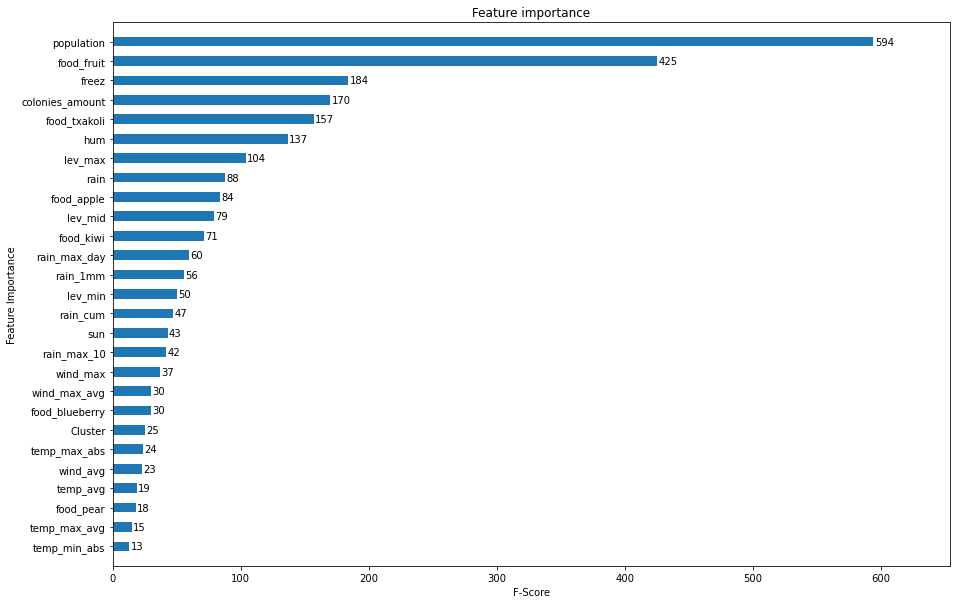

In [262]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

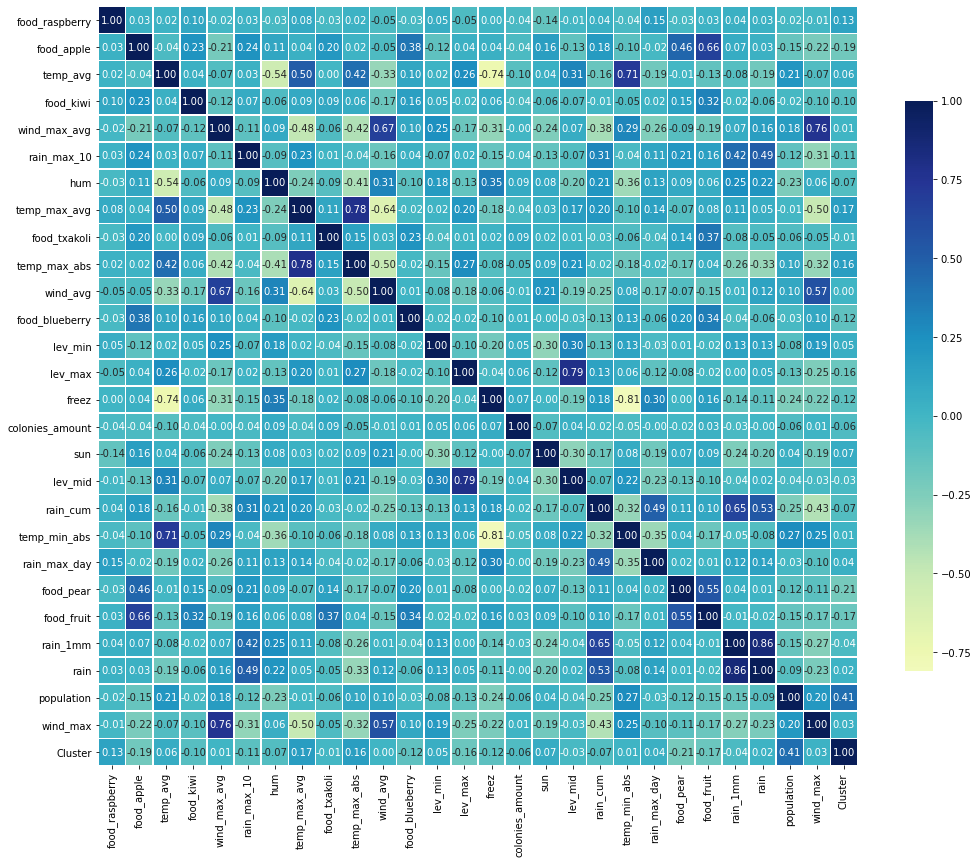

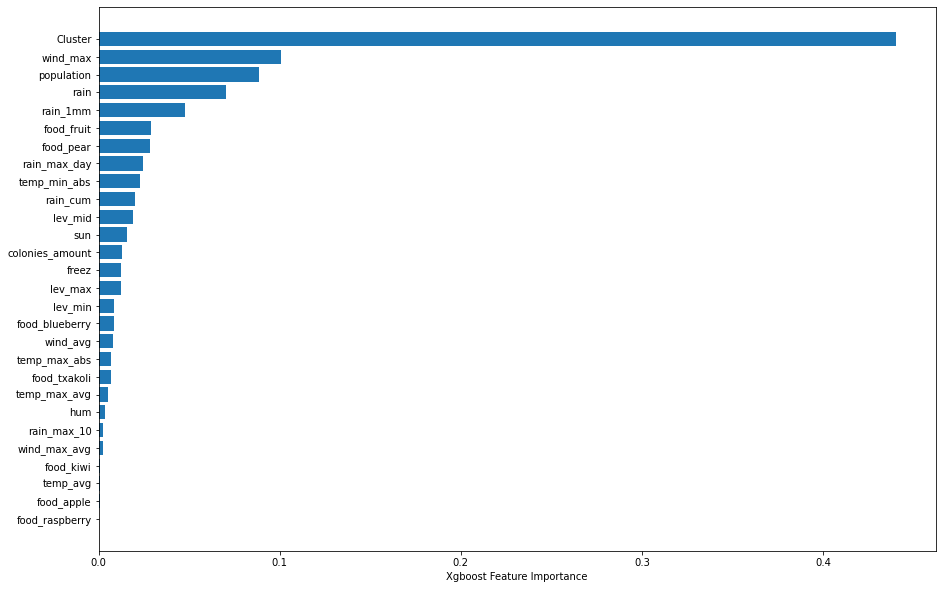

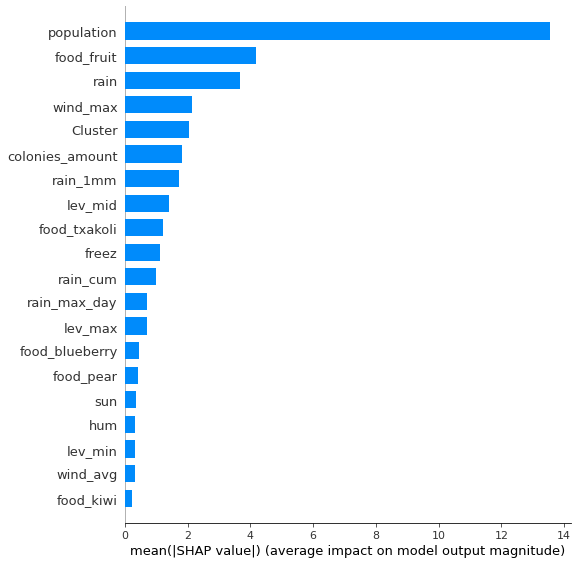

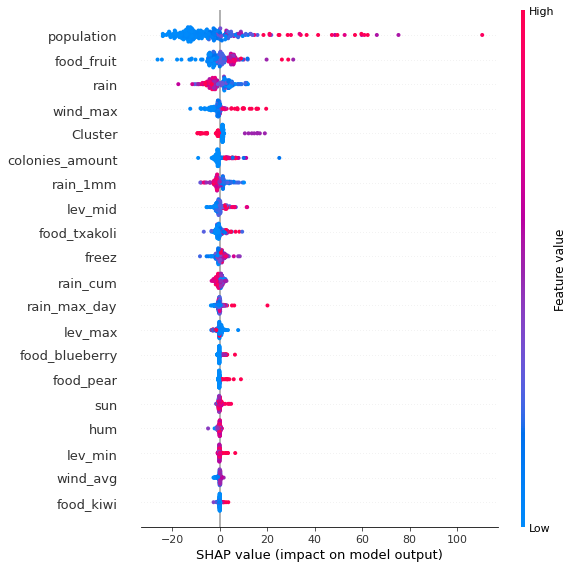

In [267]:
# Correlation Matrix
correlation_heatmap(X_scaled[X_scaled.columns[sorted_idx]])
plt.show()

# Feature importance from model.feature_importances built-in attribute
sorted_idx = model.feature_importances_.argsort()

plt.barh(X_scaled.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

# Shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)

shap.summary_plot(shap_values, X_scaled, plot_type="bar")
plt.show()

shap.summary_plot(shap_values, X_scaled)
plt.show()

#shap.dependence_plot("rain", shap_values, X_scaled)
#plt.show()

In [26]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables
# selecting the train X & y variables

# selecting the train X & y variables

# Y/Response variable have been defined previously

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = queen_train.loc[:,["population","food_txakoli","food_apple","food_kiwi","lev_max","hum","freez","Cluster"]].copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020 = queen_predict.loc[:,["population","food_txakoli","food_apple","food_kiwi","lev_max","hum","freez","Cluster"]].copy()

### Use GridSearchCV to find out the best hyperparameters for our XGBoost model with our Fitted Data

In [280]:
# Use GridSearchCV that will split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {"n_estimators":[100,50,10]}
model = GridSearchCV(XGBRegressor(),param_grid)

#
model.fit(X, y)
model.cv_results_

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and incr

{'mean_fit_time': array([0.09844518, 0.04777398, 0.01316409]),
 'std_fit_time': array([0.0086115 , 0.00325551, 0.00074615]),
 'mean_score_time': array([0.00418868, 0.00418911, 0.00399008]),
 'std_score_time': array([0.0003994 , 0.00074665, 0.0008925 ]),
 'param_n_estimators': masked_array(data=[100, 50, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 100}, {'n_estimators': 50}, {'n_estimators': 10}],
 'split0_test_score': array([0.07262973, 0.07265107, 0.08337259]),
 'split1_test_score': array([0.52590463, 0.52608581, 0.48471549]),
 'split2_test_score': array([0.57408984, 0.57452526, 0.57049576]),
 'split3_test_score': array([0.24715368, 0.24751338, 0.21357681]),
 'split4_test_score': array([-1.81332313, -1.81118886, -1.17694884]),
 'mean_test_score': array([-0.07870905, -0.07808267,  0.03504236]),
 'std_test_score': array([0.88653032, 0.88581117, 0.63119716]),
 'rank_test_score': array([3, 2, 1])}

### Choose a class of model by importing the appropriate estimator class

In [27]:
# selecting the XGBoost model and best_model hyperparameters

model = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [28]:
# refitting the model

model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [30]:
# make a prediction

prediction_2020 = model.predict(queen_predict2020)

## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [31]:
# Create a new Column with the 2020 prediction
queen_predict["nests_2020"] = prediction_2020

In [32]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48020, 48022, 48051, 48071, 48074, 48088],\
             "NOMBRE MUNICIPIO":["Bilbao", "Karrantza Harana/Valle de Carranza","Lanestosa","Muskiz","Urduña/Orduña","Ubide"],\
             "NIDOS 2020":[0,1,1,0,1,0]})

In [35]:
HEX = queen_predict.loc[:,["municip_code","municip_name_x","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [36]:
# Final check

check_data(HEX)

(112, 3) : Shape is correct.
112 : Number of unique municipalities is correct.
The Total 2020 Nests' Prediction is 2768


In [230]:
# reset max_rows to default values (used in function to see which rows did not match template)

pd.reset_option("max_rows")

In [46]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210526_XGyears_cluster_var.csv", index=False)